In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.individual.hooks as hooks
from multitask.models.individual import get_individual_model, calculate_rdm, plot_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
path_data = os.path.join('..', '..', 'data')
path_model_sequential = os.path.join('..', '..', 'results', 'individual')

In [3]:
path_figure = os.path.join('svg', 'figureS18_rdm_individual.svg')

path_pickle_2 = os.path.join('pickle', 'sequential_2.pickle')
path_pickle_5 = os.path.join('pickle', 'sequential_5.pickle')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
num_tasks = len(tasks_names)

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': None
}

data_folder = check_runs(path_model_sequential, parameters)

Found simulation in ../../results/individual with the same parameters (2022-09-27_22_43_04)


In [6]:
def _get_mean_activations(activations, num_hidden, list_numbers):
    num_classes = len(set(list_numbers))
    mean_activations = {}
    for i_layer, num_units in enumerate(num_hidden, 1):
        layer_name = f"layer{i_layer}"
        mean_activations[layer_name] = np.zeros((num_classes, num_units))
        for number in range(num_classes):
            activations_number = \
                activations[layer_name][list_numbers == number, :]
            mean_activations[layer_name][number, :] = np.mean(
                activations_number, axis=0
            )

    return mean_activations

def get_mean_activations(activations_tasks,
                         names_tasks,
                         num_hidden,
                         list_numbers):
    mean_activations_tasks = {}
    
    for name_task, activations, labels_numbers in zip(
        names_tasks, activations_tasks, list_numbers
    ):
        mean_activations_tasks[name_task] = \
            _get_mean_activations(activations,
                                  num_hidden,
                                  labels_numbers)
    
    return mean_activations_tasks

In [7]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_individual = pickle.load(handle)

In [8]:
seeds = sorted(list(results_individual.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [9]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

list_rdm_2 = []
mean_activations_2 = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_seeds):
    task_activations = []
    task_numbers = []
    indices = results_individual[seed]['indices']

    for i_task, task_name in enumerate(tasks_names):
        state_dict = results_individual[seed][task_name]['model']

        model = get_individual_model(num_hidden,
                                     device)
        model.load_state_dict(state_dict)
        model.to(device)

        task_dataset = tasks_datasets[task_name]
        test_sampler = dataset.SequentialSampler(indices['test'])
        testloader = torch.utils.data.DataLoader(task_dataset,
                                                 sampler=test_sampler,
                                                 batch_size=batch_size)

        numbers = testloader.dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        _, activations = hooks.get_layer_activations(model,
                                                     testloader,
                                                     criterion,
                                                     device=device,
                                                     disable=True)
        
        task_activations.append(activations)
        task_numbers.append(numbers)
    
    mean_activations = get_mean_activations(task_activations,
                                            tasks_names,
                                            num_hidden,
                                            task_numbers)

    rdm_dict = calculate_rdm(task_activations,
                             tasks_names,
                             num_hidden,
                             task_numbers)

    list_rdm_2.append(rdm_dict)
    mean_activations_2.append(mean_activations)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
initial_seed = 9876
tasks_names = ['parity', 'value', 'prime', 'fibonacci', 'multiples3']

parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': None
}

data_folder = check_runs(path_model_sequential, parameters)

Found simulation in ../../results/individual with the same parameters (2024-01-19_14-32-06)


In [12]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_individual = pickle.load(handle)

In [13]:
seeds = sorted(list(results_individual.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[35826, 71651, 115238, 116103, 120635, 134969, 251708, 599912, 613403, 791925]
['parity', 'value', 'prime', 'fibonacci', 'multiples3']


In [14]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [15]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

list_rdm_5 = []
mean_activations_5 = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_seeds):
    task_activations = []
    task_numbers = []
    indices = results_individual[seed]['indices']

    for i_task, task_name in enumerate(tasks_names):
        state_dict = results_individual[seed][task_name]['model']

        model = get_individual_model(num_hidden,
                                     device)
        model.load_state_dict(state_dict)
        model.to(device)

        task_dataset = tasks_datasets[task_name]
        test_sampler = dataset.SequentialSampler(indices['test'])
        testloader = torch.utils.data.DataLoader(task_dataset,
                                                 sampler=test_sampler,
                                                 batch_size=batch_size)

        numbers = testloader.dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        _, activations = hooks.get_layer_activations(model,
                                                     testloader,
                                                     criterion,
                                                     device=device,
                                                     disable=True)
        
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            tasks_names,
                                            num_hidden,
                                            task_numbers)

    rdm_dict = calculate_rdm(task_activations,
                             tasks_names,
                             num_hidden,
                             task_numbers)

    list_rdm_5.append(rdm_dict)
    mean_activations_5.append(mean_activations)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
parent_pickle = os.path.dirname(path_pickle_2)

if not os.path.exists(parent_pickle):
    os.makedirs(parent_pickle)

with open(path_pickle_2, 'wb') as f:
    pickle.dump(mean_activations_2, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_pickle_5, 'wb') as f:
    pickle.dump(mean_activations_5, f, protocol=pickle.HIGHEST_PROTOCOL)

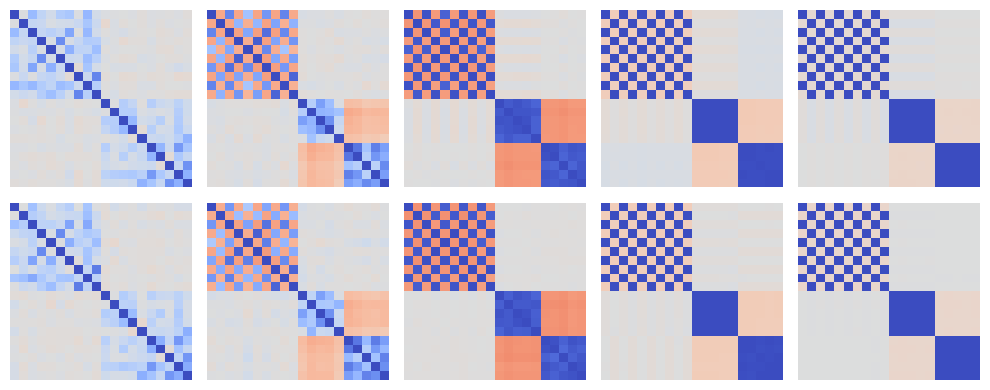

In [17]:
mean_rdm_2 = {}
mean_rdm_5 = {}

for layer in range(num_layers):
    mean_rdm_2[layer+1] = np.zeros((20, 20))
    for rdm in list_rdm_2:
        mean_rdm_2[layer+1] += rdm[layer+1]
    mean_rdm_2[layer+1] /= num_runs

for layer in range(num_layers):
    mean_rdm_5[layer+1] = np.zeros((20, 20))
    for rdm in list_rdm_5:
        mean_rdm_5[layer+1] += rdm[layer+1][:20, :20]
    mean_rdm_5[layer+1] /= num_runs

fig, ax = plt.subplots(2, num_layers, figsize=(2 * num_layers, 4))
plot_rdm(ax[0], mean_rdm_2, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
plot_rdm(ax[1], mean_rdm_5, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
fig.tight_layout()
fig.savefig(path_figure)
plt.show()